In [1]:
import sys
sys.path.append("/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/")

import json
import importlib

import pandas as pd
import polars as pl
import numpy as np
import torch

from maps.multiscreen import config
import maps.multiscreen.data_loaders as data_loaders
import maps.multiscreen.aligners as aligners
import maps.multiscreen.fitting as fitting
import maps.multiscreen.evaluate as evaluate
import maps.multiscreen.visualizers as visualizers

# --- Initialize parameters ---
pdir = "/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/template_analyses/params/"
with open(pdir + "binary_multiscreen-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir + "binary_multiscreen-split-test.json", "r") as f:
    test_params = json.load(f)
    
PALETTE = {
    "WT": "#9A9A9A",
    "FUS": "#B24745" ,
    "C9orf72": "#6A6599",
    "sporadic": "#79AF97",
    "SOD1": "#00A1D5",
    "TDP43": "#DF8F44"
}

screen_mapping = {
    "2024042034": "20250407_AWALS39_FUS-focused_screen",
    "2024042012": "20241118_AWALS35_intermediate_screen_n72",
    "2024042039": "20250626_AWALS45_Full_screen_n_96",
    "2024042020": "20250216_AWALS37_Full_screen_n96"
}

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading Data

In [2]:
from maps.screens import ImageScreen
from maps.analyses import MAP

screen_1 = ImageScreen(train_params)
screen_1.load(antibody='FUS/EEA1')

screen_2 = ImageScreen(test_params)
screen_2.load(antibody='FUS/EEA1')

screen_1.preprocess()
screen_2.preprocess()

/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(
/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(


In [3]:
screen_1.metadata = screen_1.metadata.with_columns(
    pl.col('CellLines').str.replace('11', '#11')
)
screen_1.metadata = screen_1.metadata.with_columns(
    pl.col('CellLines').str.replace('##11', '#11')
)
screen_2.metadata = screen_2.metadata.with_columns(
    pl.col('CellLines').str.replace('11', '#11')
)
screen_2.metadata = screen_2.metadata.with_columns(
    pl.col('CellLines').str.replace('##11', '#11')
)

# Aligner

In [4]:
importlib.reload(config)
importlib.reload(data_loaders)
importlib.reload(aligners)
importlib.reload(fitting)

torch.manual_seed(1126)

dataloader_config = config.DataLoaderConfig()
fit_config = config.FitConfig()
aligner_config = config.AlignerConfig()
aligner_config.n_domains = 4

transformer = fitting.DataTransformer(aligner_class=aligners.DANNAligner, 
                                      fit_config=fit_config)
transformer.fit(screen_1.data, screen_1.metadata, 
                dataloader_config,
                aligner_config)
screen_2_transform = transformer.transform(screen_2.data, screen_2.metadata, 
                                            dataloader_config,
                                            aligner_config)

transformer = fitting.DataTransformer(aligner_class=aligners.DANNAligner, 
                                      fit_config=fit_config)
transformer.fit(screen_2.data, screen_2.metadata, 
                dataloader_config,
                aligner_config)
screen_1_transform = transformer.transform(screen_1.data, screen_1.metadata, 
                                            dataloader_config,
                                            aligner_config)


Training aligner DANNAligner with 4 domains...
26 cell line labels
Epoch 10/100, Alpha: 0.422, Domain Loss: 0.5701, Label Loss: 2.2415
Epoch 20/100, Alpha: 0.740, Domain Loss: 1.1704, Label Loss: 2.2498
Epoch 30/100, Alpha: 0.896, Domain Loss: 1.2290, Label Loss: 2.2164
Epoch 40/100, Alpha: 0.960, Domain Loss: 1.2433, Label Loss: 2.1619
Epoch 50/100, Alpha: 0.985, Domain Loss: 1.2412, Label Loss: 2.1246
Epoch 60/100, Alpha: 0.995, Domain Loss: 1.2475, Label Loss: 2.0746
Epoch 70/100, Alpha: 0.998, Domain Loss: 1.2453, Label Loss: 2.0504
Epoch 80/100, Alpha: 0.999, Domain Loss: 1.2542, Label Loss: 2.0392
Epoch 90/100, Alpha: 1.000, Domain Loss: 1.2531, Label Loss: 2.0104
Epoch 100/100, Alpha: 1.000, Domain Loss: 1.2550, Label Loss: 2.0009
Training aligner DANNAligner with 4 domains...
24 cell line labels
Epoch 10/100, Alpha: 0.422, Domain Loss: 0.4147, Label Loss: 2.0633
Epoch 20/100, Alpha: 0.740, Domain Loss: 1.1218, Label Loss: 2.1436
Epoch 30/100, Alpha: 0.896, Domain Loss: 1.1889, 

# Embedding Plots

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


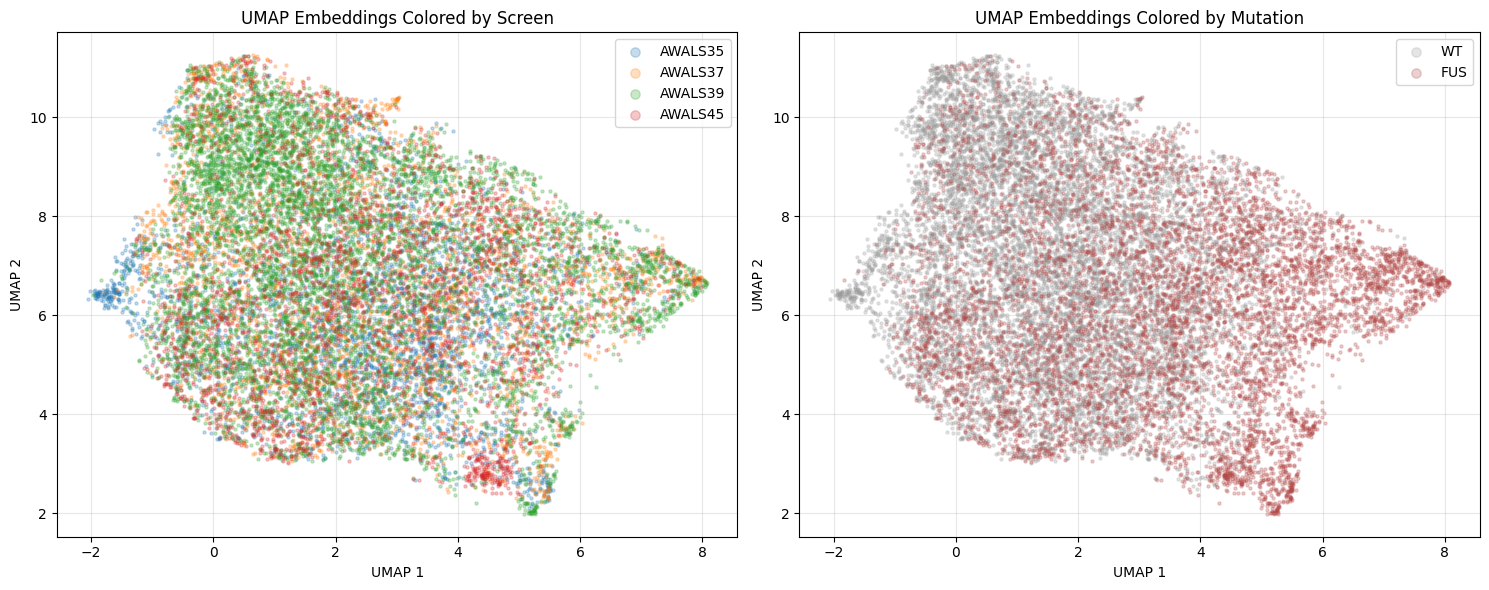

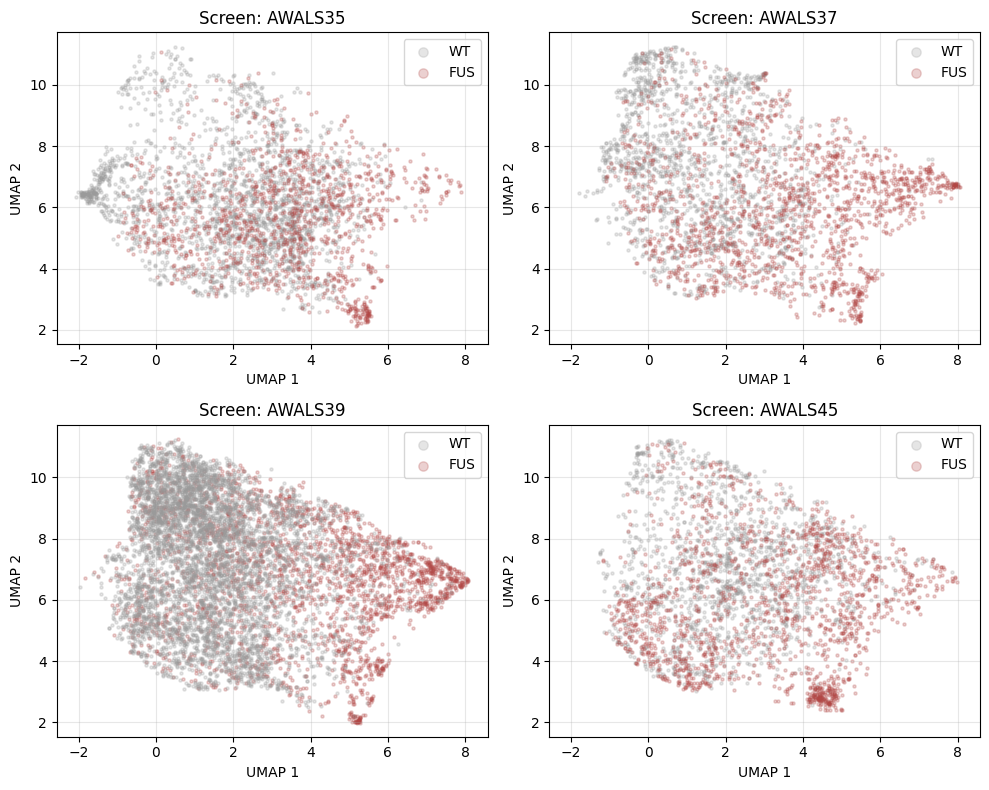

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


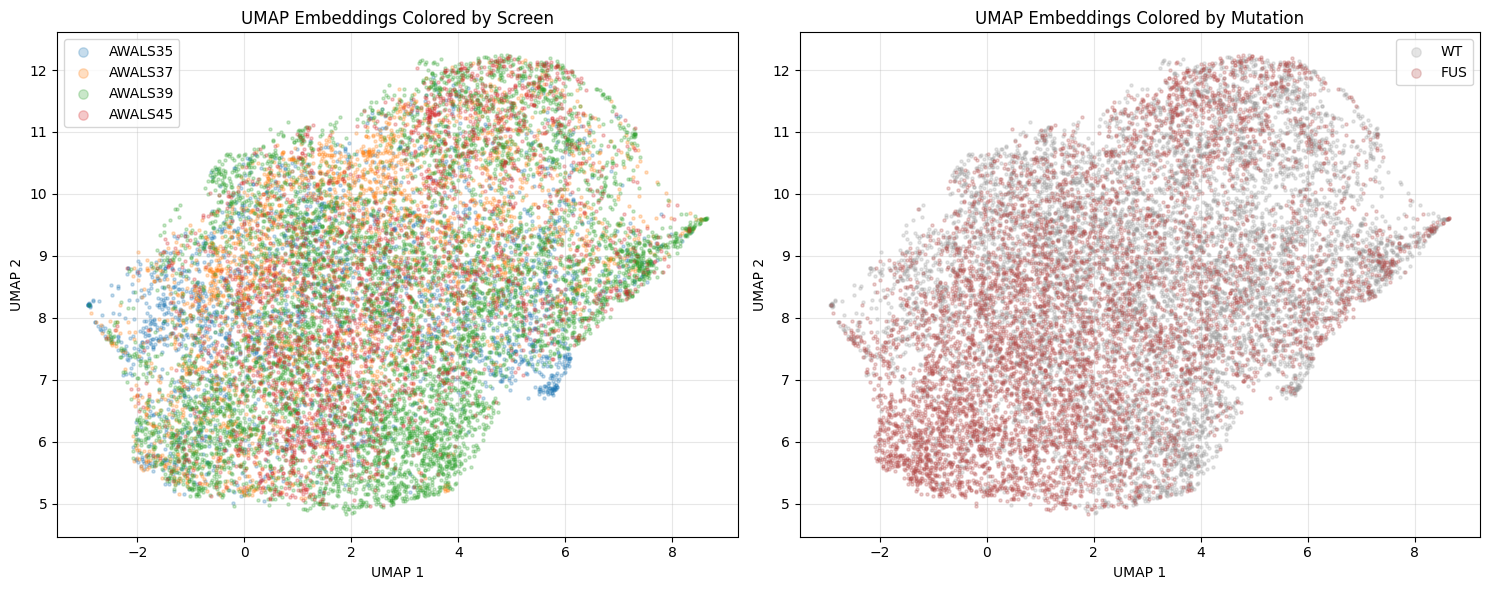

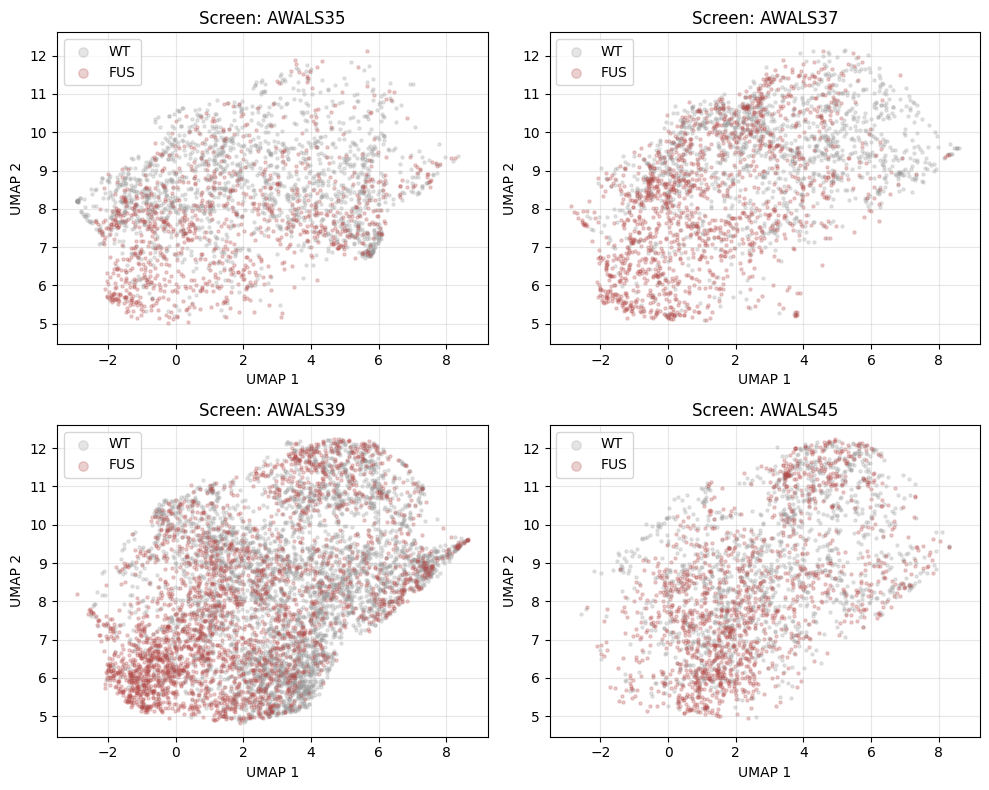

In [5]:
import umap
importlib.reload(visualizers)

for screens in range(2):
    reducer = umap.UMAP(random_state=42)
    if screens == 0:
        data = screen_1_transform
    else:
        data = screen_2_transform
    
    umap_embeddings = reducer.fit_transform(
        data[[f'aligned_feature_{i}' for i in range(aligner_config.output_dim)]]
    )
    umap_embeddings = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2']).merge(
        data.loc[:, ~data.columns.str.contains("aligned")], left_index=True, right_index=True
    )
    umap_embeddings['Screen'] = umap_embeddings['Screen'].map(screen_mapping).apply(lambda x: x.split('_')[1])
    visualizers.plot_umap_embeddings(umap_embeddings)
    visualizers.plot_umap_embeddings_stratified(umap_embeddings)

# MAPS Classification

In [6]:
screen_1_original = screen_1.data.to_pandas().copy()
screen_2_original = screen_2.data.to_pandas().copy()

In [7]:
screen_1.data = pl.from_dataframe(screen_1_transform.drop(columns=['CellLines', 'Mutations', 'Screen']))
screen_2.data = pl.from_dataframe(screen_2_transform.drop(columns=['CellLines', 'Mutations', 'Screen']))

In [8]:
from maps.analyses import MAP

maps_1 = MAP(screen_1)
maps_1.fit()

maps_2 = MAP(screen_2)
maps_2.fit()

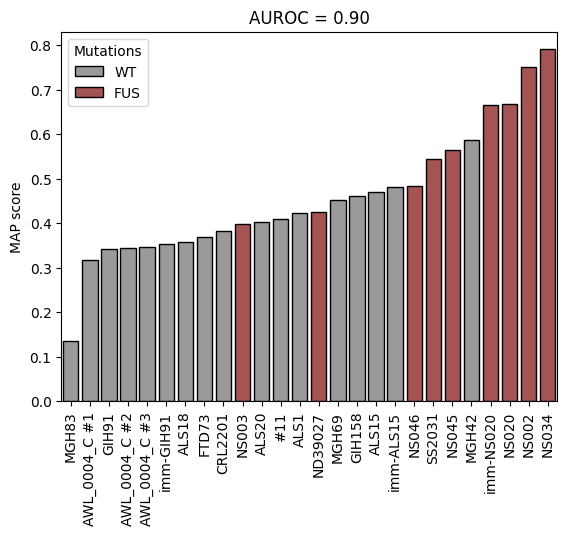

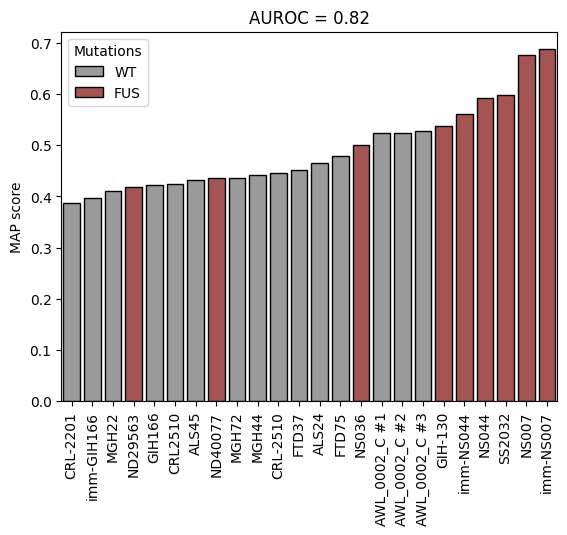

In [9]:
import pandas as pd
from maps.utils import group_predicted, fit_size_model, adjust_map_scores
from maps.figures import plot_grouped, plot_map_adjustment

# groups = ["CellLines", "Mutations", "Well"] 
# grouped_pred = group_predicted(maps_1.fitted["predicted"], groups, "Ypred")

raw_pred_1 = maps_1.fitted["predicted"] \
    .filter(pl.col("Mutations").is_in(["FUS", "WT"]))
    
fig1 = plot_grouped(
    df=raw_pred_1, 
    y="Ypred",
    x="CellLines",
    hue="Mutations",
    ylab="MAP score",
    palette=PALETTE
)

raw_pred_2 = maps_2.fitted["predicted"] \
    .filter(pl.col("Mutations").is_in(["FUS", "WT"]))

fig2 = plot_grouped(
    df=raw_pred_2,
    y="Ypred",
    x="CellLines",
    hue="Mutations",
    ylab="MAP score",
    palette=PALETTE
)

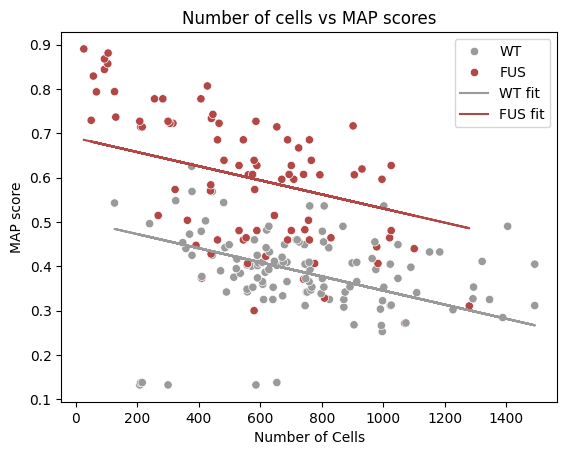

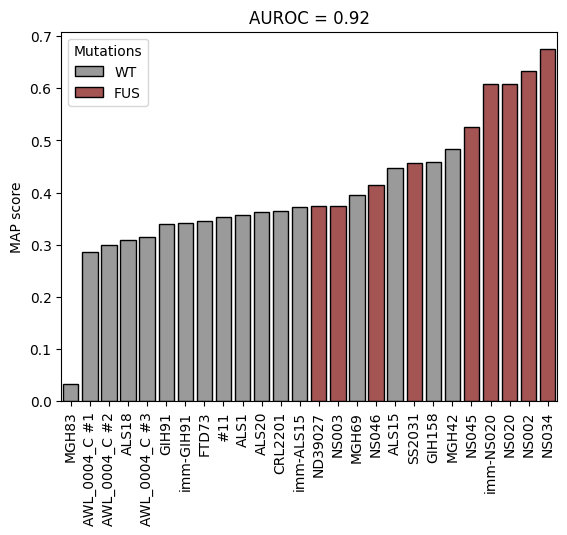

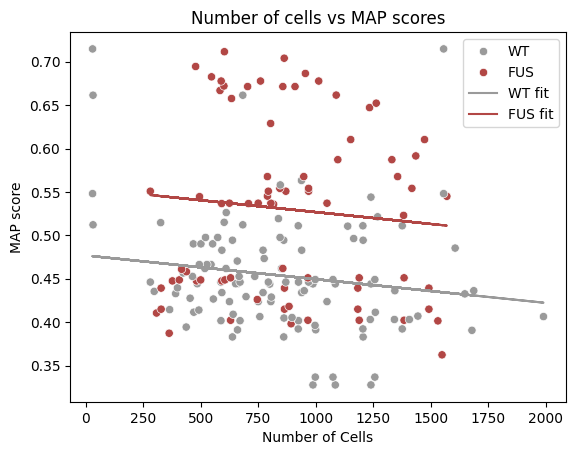

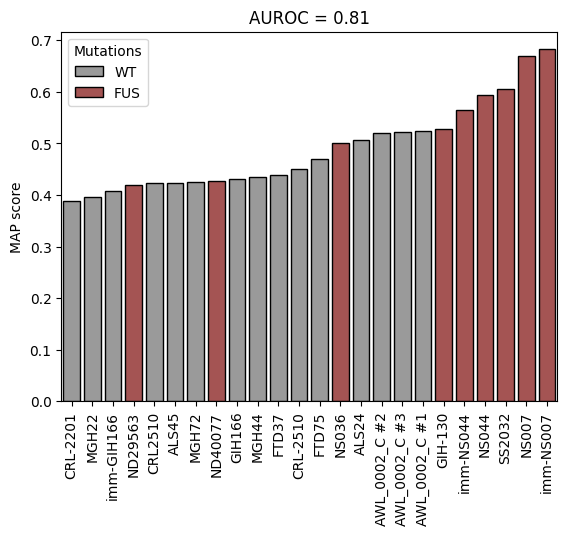

In [10]:
groups = ["CellLines", "Mutations", "Well"] 

# Fit size adjustment model for figure
grouped_pred_1 = group_predicted(raw_pred_1, groups, "Ypred")
counts_1 = screen_1.metadata.select(["Well", "NCells"]).to_pandas()
df_1 = pd.merge(grouped_pred_1, counts_1, on="Well") 
model_1, X_1 = fit_size_model(df_1)
adjusted_1 = adjust_map_scores(df_1, X_1, model_1)
adj_pred_1 = pl.DataFrame(adjusted_1) \
        .filter(pl.col("Mutations").is_in(["FUS", "WT"]))
        
plot_map_adjustment(
    df=df_1, 
    model=model_1, 
    X=X_1, 
    sporadics=False
)  

fig = plot_grouped(
    df=adj_pred_1, 
    y="Score",
    x="CellLines",
    hue="Mutations",
    ylab="MAP score",
    palette=PALETTE
)

groups = ["CellLines", "Mutations", "Well"] 

# Fit size adjustment model for figure
grouped_pred_2 = group_predicted(raw_pred_2, groups, "Ypred")
counts_2 = screen_2.metadata.select(["Well", "NCells"]).to_pandas()
df_2 = pd.merge(grouped_pred_2, counts_2, on="Well") 
model_2, X_2 = fit_size_model(df_2)
adjusted_2 = adjust_map_scores(df_2, X_2, model_2)
adj_pred_2 = pl.DataFrame(adjusted_2) \
        .filter(pl.col("Mutations").is_in(["FUS", "WT"]))
        
plot_map_adjustment(
    df=df_2, 
    model=model_2, 
    X=X_2, 
    sporadics=False
)  

fig = plot_grouped(
    df=adj_pred_2, 
    y="Score",
    x="CellLines",
    hue="Mutations",
    ylab="MAP score",
    palette=PALETTE
)


